In [57]:
import numpy as np 
import random
import matplotlib.pyplot as plt
import scipy.stats as st 
from scipy.stats import norm
from scipy.stats import burr12
from scipy.fft import fft, ifft
import scipy.linalg as linalg
from scipy.optimize import minimize
import collections 
import time
from itertools import chain
import timeit
import os
import pickle

In [125]:
#load files
results_dir = "simulation_results/concentration" 
kernels = ["kernel_k3", "kernel_k4"]
k_values = [1, 5, 15, 50]  

# Initialize a dictionary to store the data
data = {kernel: {k: [] for k in k_values} for kernel in kernels}

# Load data from pickle files
for filename in os.listdir(results_dir):
    if filename.endswith('.pkl'):
        # Extracting parameters from filename
        parts = filename.replace('.pkl', '').split('_')
        N = int(parts[1][1:])  # Extract N value
        k = int(parts[2][1:])  # Extract k value
        kernel = '_'.join(parts[3:])  # Reconstruct kernel name

        filepath = os.path.join(results_dir, filename)
        with open(filepath, 'rb') as file:
            results = pickle.load(file)
            # Store results under the corresponding kernel and k
            data[kernel][k].append((N, results))



correct_denominator = np.sqrt(10)

# Load data from pickle files and correct the confidence intervals
for kernel in kernels:
    for k in k_values:
        for N, results in data[kernel][k]:
            # Load the means and sigma
            means = np.array(results["means"])
            sigma = np.array(results["sigma"])

            # Recalculate the correct confidence intervals
            c_ok = st.norm.ppf(1 - 0.05 / 2)  
            correct_lower_bound = means - c_ok * sigma / correct_denominator
            correct_upper_bound = means + c_ok * sigma / correct_denominator

            # Replace the incorrect bounds in the data dictionary
            results["lower_bound"] = correct_lower_bound
            results["upper_bound"] = correct_upper_bound

In [126]:
def c(t, k):
    return np.exp(-t) * (k**(k-1) / np.math.factorial(k)) * (1 - np.exp(-t))**(k-1) * np.exp(-k*(1-np.exp(-t)))


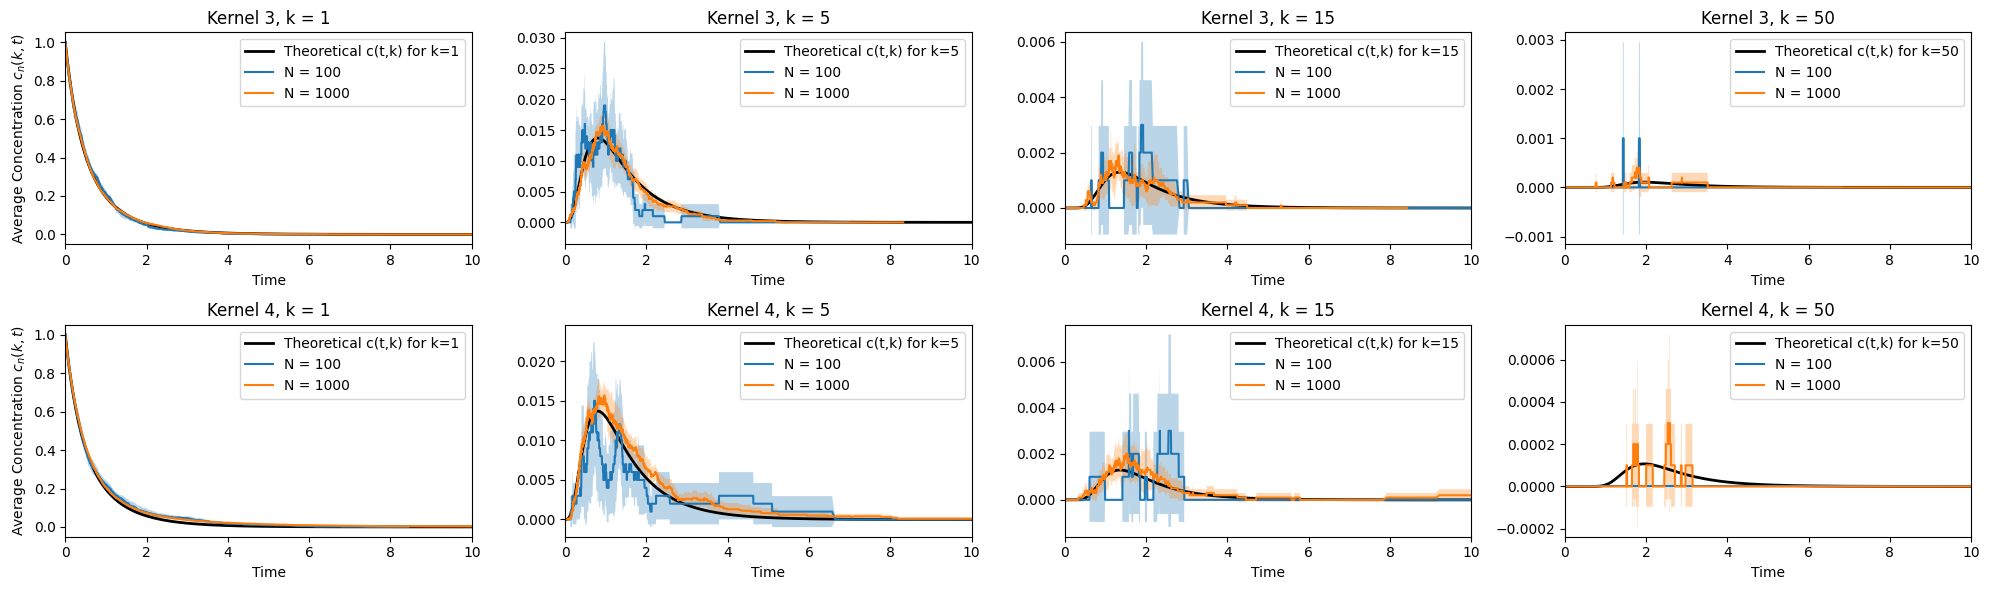

In [127]:
# Plotting concentrations
t_values = np.linspace(0, 10, 200)
N_list = [1000,100]
fig, axs = plt.subplots(len(kernels), len(k_values), figsize=(5 * len(k_values), 3 * len(kernels)), squeeze=False)

for row_idx, kernel in enumerate(kernels):
    for col_idx, k in enumerate(k_values):
        ax = axs[row_idx, col_idx]

        # Plot theoretical curve only once
        c_values = [c(t, k) for t in t_values]
        ax.plot(t_values, c_values, label=f'Theoretical c(t,k) for k={k}', color='black', linewidth=2)

        # Plot each N value in the same subplot
        sorted_results = sorted(data[kernel][k], key=lambda x: x[0])
        for N, results in sorted_results:
            if N in N_list:
                ax.plot(results["J_sorted"], results["means"], label=f'N = {N}')
                ax.fill_between(results["J_sorted"], results["lower_bound"], results["upper_bound"], alpha=0.3)
           
        ax.set_title(f'Kernel {kernel[-1]}, k = {k}')
        ax.set_xlabel('Time')
        ax.set_xlim(0,10)
        if col_idx == 0:
            ax.set_ylabel('Average Concentration $c_n(k,t)$')
        ax.legend()

plt.tight_layout()
plt.show()

In [115]:
results_dir = "simulation_results/moments"  # Correct directory
kernels = ["kernel_k3", "kernel_k4"]
N_values = [100, 1000]  # Assuming you're only interested in files with N=100

# Initialize a dictionary to store the data
data = {kernel: {N: None for N in N_values} for kernel in kernels}

# Load data from pickle files
for filename in os.listdir(results_dir):
    if filename.endswith('.pkl'):
        # Extracting parameters from filename
        parts = filename.replace('.pkl', '').split('_')
        # Assuming the filename structure is like 'results_N200_kernel_k3.pkl'
        N = int(parts[1][1:])  # Extract N value
        kernel = '_'.join(parts[2:])  # Reconstruct kernel name

        # Check if the N and kernel values are the ones we're interested in
        if N in N_values and kernel in kernels:
            filepath = os.path.join(results_dir, filename)
            with open(filepath, 'rb') as file:
                data[kernel][N] = pickle.load(file)
                #print(f"Loaded data for N={N}, kernel={kernel}")
correct_denominator = np.sqrt(10)

for kernel in kernels:
    for N in N_values:
        if data[kernel][N] is not None:
            results = data[kernel][N]
            means = np.array(results["means"])
            sigma = np.array(results["sigma"])

            # Recalculate the correct confidence intervals
            c_ok = st.norm.ppf(1 - 0.05 / 2)  
            correct_lower_bound = means - c_ok * sigma / correct_denominator
            correct_upper_bound = means + c_ok * sigma / correct_denominator

            # Replace the incorrect bounds in the data dictionary
            results["lower_bound"] = correct_lower_bound
            results["upper_bound"] = correct_upper_bound


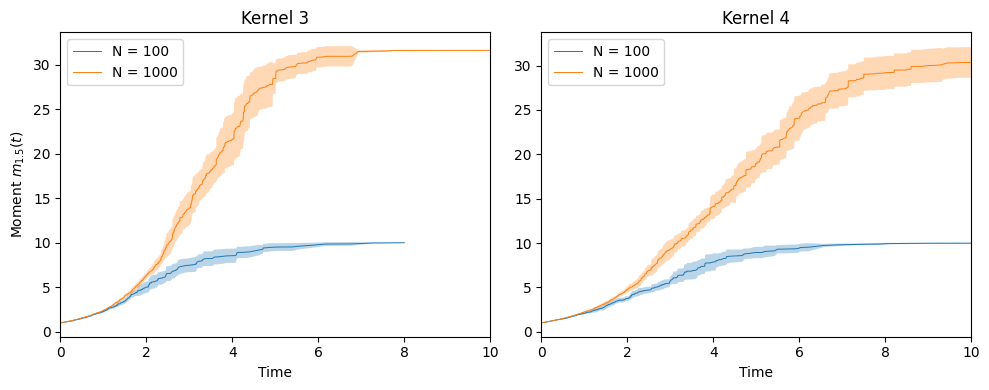

In [116]:

# Setup the figure for the subplots, one for each kernel
fig, axs = plt.subplots(1, len(kernels), figsize=(5 * len(kernels), 4), squeeze=False)

# Iterate over each kernel
for idx, kernel in enumerate(kernels):
    ax = axs[0, idx]  # Select the subplot for the current kernel

    # Iterate over each N value and plot its data
    for N in N_values:
        results = data[kernel][N]
        if results is not None:
            ax.plot(results["J_sorted"], results["means"], label=f'N = {N}', linewidth = 0.7)
            ax.fill_between(results["J_sorted"], results["lower_bound"], results["upper_bound"], alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'No Data for N=' + str(N), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    ax.set_xlim(0, 10)
    #ax.set_ylim(0, 5)
    ax.set_xlabel('Time')
    ax.set_ylabel('Moment $m_{1.5}(t)$') if idx == 0 else None
    ax.set_title(f'Kernel {kernel[8]}')
    ax.legend()

plt.tight_layout()
plt.show()


In [120]:
# Define the directory where the results are stored
results_dir = "simulation_results/gelation" 

# Initialize a dictionary to store the data
# We'll use a default dictionary to handle keys that don't exist yet
from collections import defaultdict
data = defaultdict(lambda: defaultdict(list))

# Load data from pickle files
for filename in os.listdir(results_dir):
    if filename.endswith('.pkl'):
        # Extracting parameters from filename
        parts = filename.replace('.pkl', '').split('_')
        
        # Extracting N and kernel values
        N = int(parts[1][1:])  # This will convert 'N100' to 100
        kernel = '_'.join(parts[2:4])  # This will join 'kernel' and 'ka1' (for example) to 'kernel_ka1'

        # Assuming that the k value is always 1 as per the provided example
        k = 1  # Or extract the k value from the kernel string if it varies

        filepath = os.path.join(results_dir, filename)
        with open(filepath, 'rb') as file:
            results = pickle.load(file)
            # Store results under the corresponding kernel and k
            data[kernel][k].append((N, results))

correct_denominator = np.sqrt(10)

# Load data from pickle files and correct the confidence intervals
for kernel in kernels:
    for k in k_values:
        for N, results in data[kernel][k]:
            # Load the means and sigma
            means = np.array(results["means"])
            sigma = np.array(results["sigma"])

            # Recalculate the correct confidence intervals
            c_ok = st.norm.ppf(1 - 0.05 / 2)  
            correct_lower_bound = means - c_ok * sigma / correct_denominator
            correct_upper_bound = means + c_ok * sigma / correct_denominator

            # Replace the incorrect bounds in the data dictionary
            results["lower_bound"] = correct_lower_bound
            results["upper_bound"] = correct_upper_bound

range(0, 4)


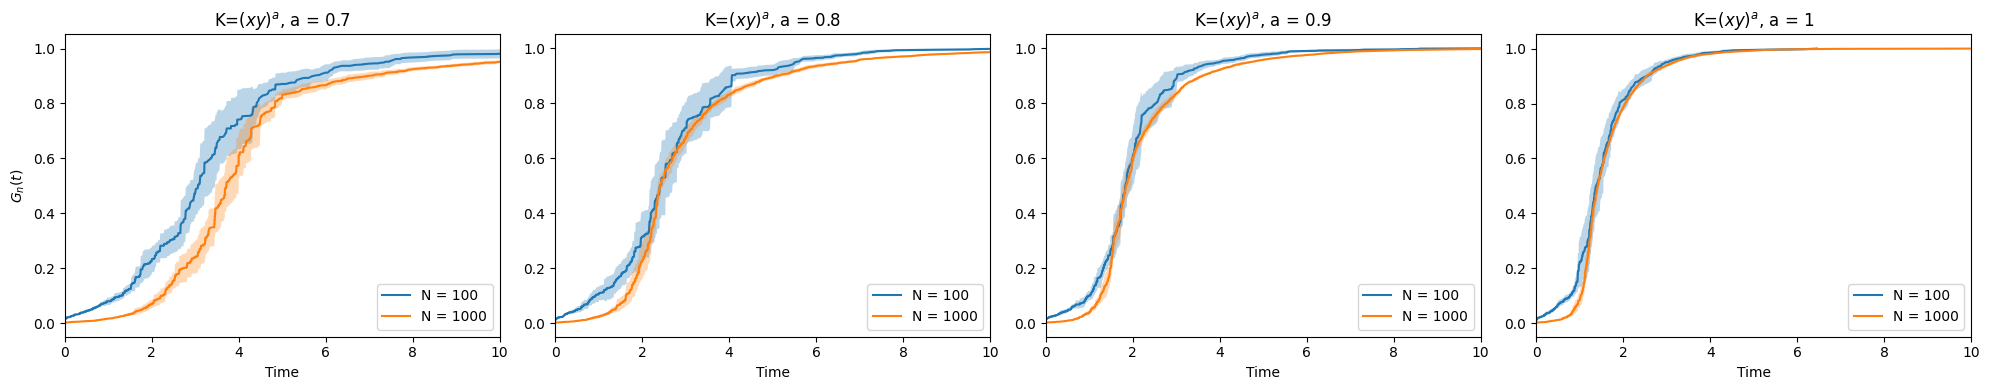

In [123]:
#plotting gelation curves

kernels = ["kernel_ka1", "kernel_ka2", "kernel_ka3", "kernel_k2"]
a = [0.7,0.8,0.9,1]
print(range(len(a)))

# Setup the figure and axes for the 4 subplots (one for each kernel)
fig, axs = plt.subplots(1, len(kernels), figsize=(5 * len(kernels), 4), squeeze=False)

# Plot the data for each kernel
for idx, kernel in enumerate(kernels):
    ax = axs[0, idx]
    
    # Since we are not differentiating by k values, we assume k_values contains only one value
    k = list(data[kernel].keys())[0]  # Get the first (and assumed only) k value for the kernel
    
    # Plot each N value in the same subplot
    for N, results in data[kernel][k]:
        ax.plot(results["J_sorted"], results["means"], label=f'N = {N}')
        ax.fill_between(results["J_sorted"], results["lower_bound"], results["upper_bound"], alpha=0.3)
    if idx < len(a):
        ax.set_title(f'K=$(xy)^a$, a = {a[idx]}')
        
    ax.set_xlim(0,10)
    ax.set_xlabel('Time')
    
    
    if idx == 0:
        ax.set_ylabel('$G_n(t)$')
    ax.legend()
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [119]:
def find_times(results):
    first_time_gelation_one = None
    time_of_max_gelation = None
    max_gelation = None

    for time, gelation in zip(results["J_sorted"], results["means"]):
        # Check if gelation has reached 1 for the first time
        if first_time_gelation_one == 0.8:
            first_time_gelation_one = time
        
        # Check if this is the maximum gelation so far
        if max_gelation is None or gelation > max_gelation:
            max_gelation = gelation
            time_of_max_gelation = time

    return first_time_gelation_one, time_of_max_gelation

# Example usage:
# Assuming 'data' is the dictionary containing your simulation results:
for kernel in kernels:
    k = list(data[kernel].keys())[0]  # Assuming k is always 1 as before
    for N, results in data[kernel][k]:
        first_time_gelation_one, time_of_max_gelation = find_times(results)
        print(f'For N = {N} in {kernel}:')
        print(f' - G reaches 1 at time {first_time_gelation_one}')
        print(f' - G reaches its maximum value at time {time_of_max_gelation.round(2)}')


For N = 100 in kernel_ka1:
 - G reaches 1 at time None
 - G reaches its maximum value at time 22.23
For N = 1000 in kernel_ka1:
 - G reaches 1 at time None
 - G reaches its maximum value at time 10.38
For N = 100 in kernel_ka2:
 - G reaches 1 at time None
 - G reaches its maximum value at time 14.29
For N = 1000 in kernel_ka2:
 - G reaches 1 at time None
 - G reaches its maximum value at time 11.03
For N = 100 in kernel_ka3:
 - G reaches 1 at time None
 - G reaches its maximum value at time 10.11
For N = 1000 in kernel_ka3:
 - G reaches 1 at time None
 - G reaches its maximum value at time 13.36
For N = 100 in kernel_k2:
 - G reaches 1 at time None
 - G reaches its maximum value at time 6.46
For N = 1000 in kernel_k2:
 - G reaches 1 at time None
 - G reaches its maximum value at time 10.0
